
# The project

The goal is to visualize the University of Rennes 1 timetable.

The data scraped from: https://planning.univ-rennes1.fr

Possible Features :

- [ ] Visualize working hours 
- [ ] Visualize Rooms occupation
- [ ] Visualize the campus heat map
- [ ] Predict the population at a given time

# The parsing

In [125]:
import pandas as pd
import icalendar
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
data_file = 'data/esir_2022-2023.ics'
data_name = 'ESIR (2022-2023)'


# data_file = 'data/beaulieu_2022-2023.ics'
# data_name = 'UR1 Beaulieu (2022-2023)'


# data_file = 'data/beaulieu_S1_2022-2023.ics'
# data_name = 'UR1 Beaulieu S1 (2022-2023)'


# data_file = 'data/beaulieu_S2_2022-2023.ics'
# data_name = 'UR1 Beaulieu S2 (2022-2023)'

In [142]:
# Read the iCalendar file
with open(data_file, 'rb') as f:
    cal_data = f.read()

# Parse the iCalendar object (Very time consuming)
cal = icalendar.Calendar.from_ical(cal_data)
events = cal.walk('VEVENT')

In [143]:
# show the field names of an event
list(events[0].keys())

['DTSTAMP',
 'DTSTART',
 'DTEND',
 'SUMMARY',
 'LOCATION',
 'DESCRIPTION',
 'UID',
 'CREATED',
 'LAST-MODIFIED',
 'SEQUENCE']

In [144]:
# Define the parse_event utility function
# In here we can define what to keep from the event
# Possible fields are:
# ['DTSTAMP', 'DTSTART', 'DTEND', 'SUMMARY', 'LOCATION', 'DESCRIPTION', 'UID', 'CREATED', 'LAST-MODIFIED', 'SEQUENCE']
def parse_event(event):
    row = {}
    row['start_time'] = event['DTSTART'].dt
    row['end_time'] = event['DTEND'].dt
    row['summary'] = event['SUMMARY']
    row['description'] = event['DESCRIPTION']
    row['location'] = event.get('LOCATION', None)
    return row

In [145]:
# Extract event details
data = [parse_event(event) for event in events]

# Create a DataFrame
raw_df = pd.DataFrame(data)

In [146]:
raw_df.head()

,start_time,end_time,summary,description,location
0,2022-10-18 14:15:00+00:00,2022-10-18 16:15:00+00:00,TPs A PROG,\n\n002 VUE TOUT ESIR 1 FISE\n002 vue ESIR 1 S...,B41 - 104 priorité LV (Linux)
1,2023-04-03 06:00:00+00:00,2023-04-03 08:00:00+00:00,TD SPE SNSF MONU-S8,\n\n009 FISA SNR2 Parc.SNSF (S8)\n009 TOUT ...,B41 - 004
2,2023-02-09 07:00:00+00:00,2023-02-09 11:00:00+00:00,INENT-S8,\n\n003 VUE TOUT ESIR2 FISE\n003 vue IN ESIR2\...,B41 - 104 priorité LV (Linux)
3,2023-01-06 09:15:00+00:00,2023-01-06 11:15:00+00:00,TD MATH-S1 GR A,\n\n001-1 VUE CUPGE 1\nCUPGE1 GR A\nKARFOUL Ah...,B41 - 004
4,2022-09-27 14:15:00+00:00,2022-09-27 16:15:00+00:00,ONum1 S6 TD,\n\n6 ESIR 1 FISA MATERIAUX\n005 VUE ESIR1 FIS...,B41 - 104 priorité LV (Linux)


# Clean the dataframe

## Step 1 : Remove time offset

We remove the time offset from the data because for french people, the time is always in UTC+1 and the data was exported in UTC-0.

So we **add 1 hour to each timestamps** in the data.

In [147]:
# add 1 hour to the start_time and end_time

df = raw_df.copy()

df['start_time'] = raw_df['start_time'] + pd.Timedelta(hours=1)
df['end_time'] = raw_df['end_time'] + pd.Timedelta(hours=1)
df.head()

,start_time,end_time,summary,description,location
0,2022-10-18 15:15:00+00:00,2022-10-18 17:15:00+00:00,TPs A PROG,\n\n002 VUE TOUT ESIR 1 FISE\n002 vue ESIR 1 S...,B41 - 104 priorité LV (Linux)
1,2023-04-03 07:00:00+00:00,2023-04-03 09:00:00+00:00,TD SPE SNSF MONU-S8,\n\n009 FISA SNR2 Parc.SNSF (S8)\n009 TOUT ...,B41 - 004
2,2023-02-09 08:00:00+00:00,2023-02-09 12:00:00+00:00,INENT-S8,\n\n003 VUE TOUT ESIR2 FISE\n003 vue IN ESIR2\...,B41 - 104 priorité LV (Linux)
3,2023-01-06 10:15:00+00:00,2023-01-06 12:15:00+00:00,TD MATH-S1 GR A,\n\n001-1 VUE CUPGE 1\nCUPGE1 GR A\nKARFOUL Ah...,B41 - 004
4,2022-09-27 15:15:00+00:00,2022-09-27 17:15:00+00:00,ONum1 S6 TD,\n\n6 ESIR 1 FISA MATERIAUX\n005 VUE ESIR1 FIS...,B41 - 104 priorité LV (Linux)


## Step 2 : Remove the useless data

Sometime, the data is not relevant, for example, there are events for holidays that start at 7:00 and end at 22:00 which falsify the data.

To filter those events, we will create a column **duration** which is the difference between the end and the start of the event. 
If the duration is more than 10 hours, we will remove the event. 

In [148]:
df['duration'] = df['end_time'] - df['start_time']
hours10 = pd.Timedelta(hours=10)

df = df[df['duration'] < hours10]
df.head()

,start_time,end_time,summary,description,location,duration
0,2022-10-18 15:15:00+00:00,2022-10-18 17:15:00+00:00,TPs A PROG,\n\n002 VUE TOUT ESIR 1 FISE\n002 vue ESIR 1 S...,B41 - 104 priorité LV (Linux),0 days 02:00:00
1,2023-04-03 07:00:00+00:00,2023-04-03 09:00:00+00:00,TD SPE SNSF MONU-S8,\n\n009 FISA SNR2 Parc.SNSF (S8)\n009 TOUT ...,B41 - 004,0 days 02:00:00
2,2023-02-09 08:00:00+00:00,2023-02-09 12:00:00+00:00,INENT-S8,\n\n003 VUE TOUT ESIR2 FISE\n003 vue IN ESIR2\...,B41 - 104 priorité LV (Linux),0 days 04:00:00
3,2023-01-06 10:15:00+00:00,2023-01-06 12:15:00+00:00,TD MATH-S1 GR A,\n\n001-1 VUE CUPGE 1\nCUPGE1 GR A\nKARFOUL Ah...,B41 - 004,0 days 02:00:00
4,2022-09-27 15:15:00+00:00,2022-09-27 17:15:00+00:00,ONum1 S6 TD,\n\n6 ESIR 1 FISA MATERIAUX\n005 VUE ESIR1 FIS...,B41 - 104 priorité LV (Linux),0 days 02:00:00


# Feature : Visualize activity per hour of the week

## Step 1 : For each hour of the week, count the number of events that are happening

In [149]:

# For each hour of the week, count the number of events that are happening
def getNearestHour( dt ):
    if dt.minute > 30:
        return dt.hour+1
    else:
        return dt.hour
 

hours = Counter()

for event in df.itertuples():
    start_time = event.start_time
    end_time = event.end_time
    cursor = start_time
    day = start_time.day_name()
    while cursor < end_time:
        hours[(getNearestHour(cursor), day)] += 1     
        cursor += pd.Timedelta(hours=1)

# Create a DataFrame from the Counter
hours_df = pd.DataFrame.from_dict(hours, orient='index', columns=['count'])
# make the index a multiindex
hours_df.index = pd.MultiIndex.from_tuples(hours_df.index, names=['hour', 'day'])
hours_df.head()

count
hour day            
15   Tuesday     393
16   Tuesday     320
7    Monday      121
8    Monday      313
     Thursday    381

## Step 2 : Get quartiles for the colormap

Because there are a lot of data and some that are outliers, we will use quartiles to get the colormap min and max.

The minimum will be the first quartile and the maximum will be the third quartile.

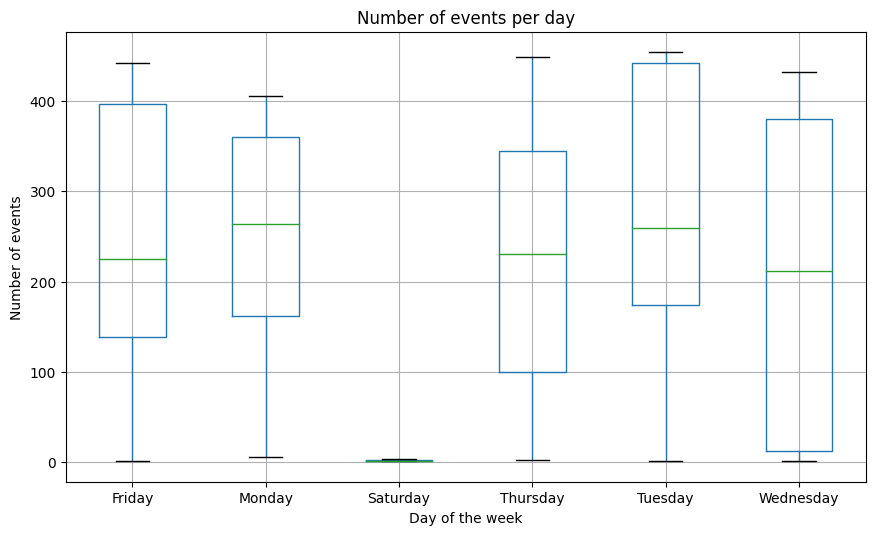

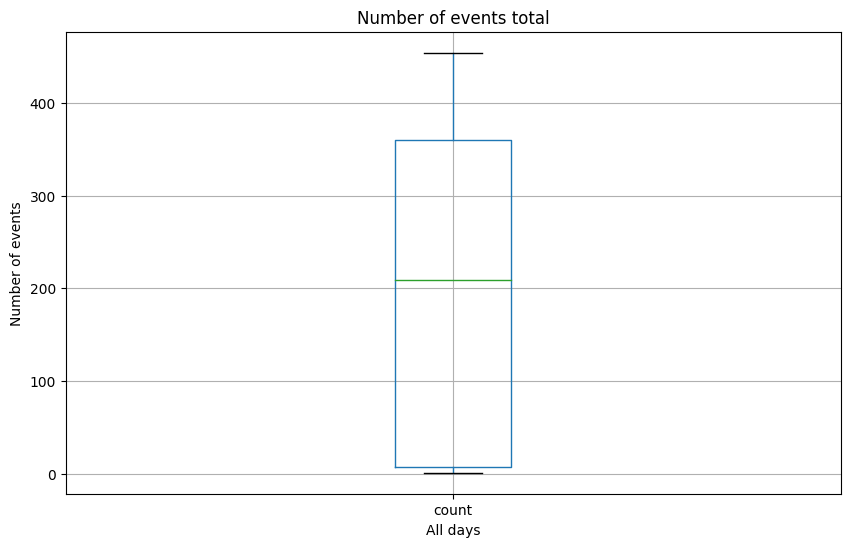

In [150]:
# boxplot
hours_df.boxplot(column='count', by='day', figsize=(10, 6))
plt.title('Number of events per day')
plt.suptitle('')
plt.xlabel('Day of the week')
plt.ylabel('Number of events')
plt.show()


hours_df.boxplot(column='count', figsize=(10, 6))
plt.title('Number of events total')
plt.xlabel('All days')
plt.ylabel('Number of events')
plt.show()


In [151]:
Q1 = hours_df['count'].quantile(0.25)
Q3 = hours_df['count'].quantile(0.80)

print(f'Q1: {Q1}')
print(f'Q3: {Q3}')

Q1: 6.75
Q3: 393.0


## Step 2 : Visualize the data

Text(0.5, 1.1, 'Hours count heatmap of ESIR (2022-2023) schedule')

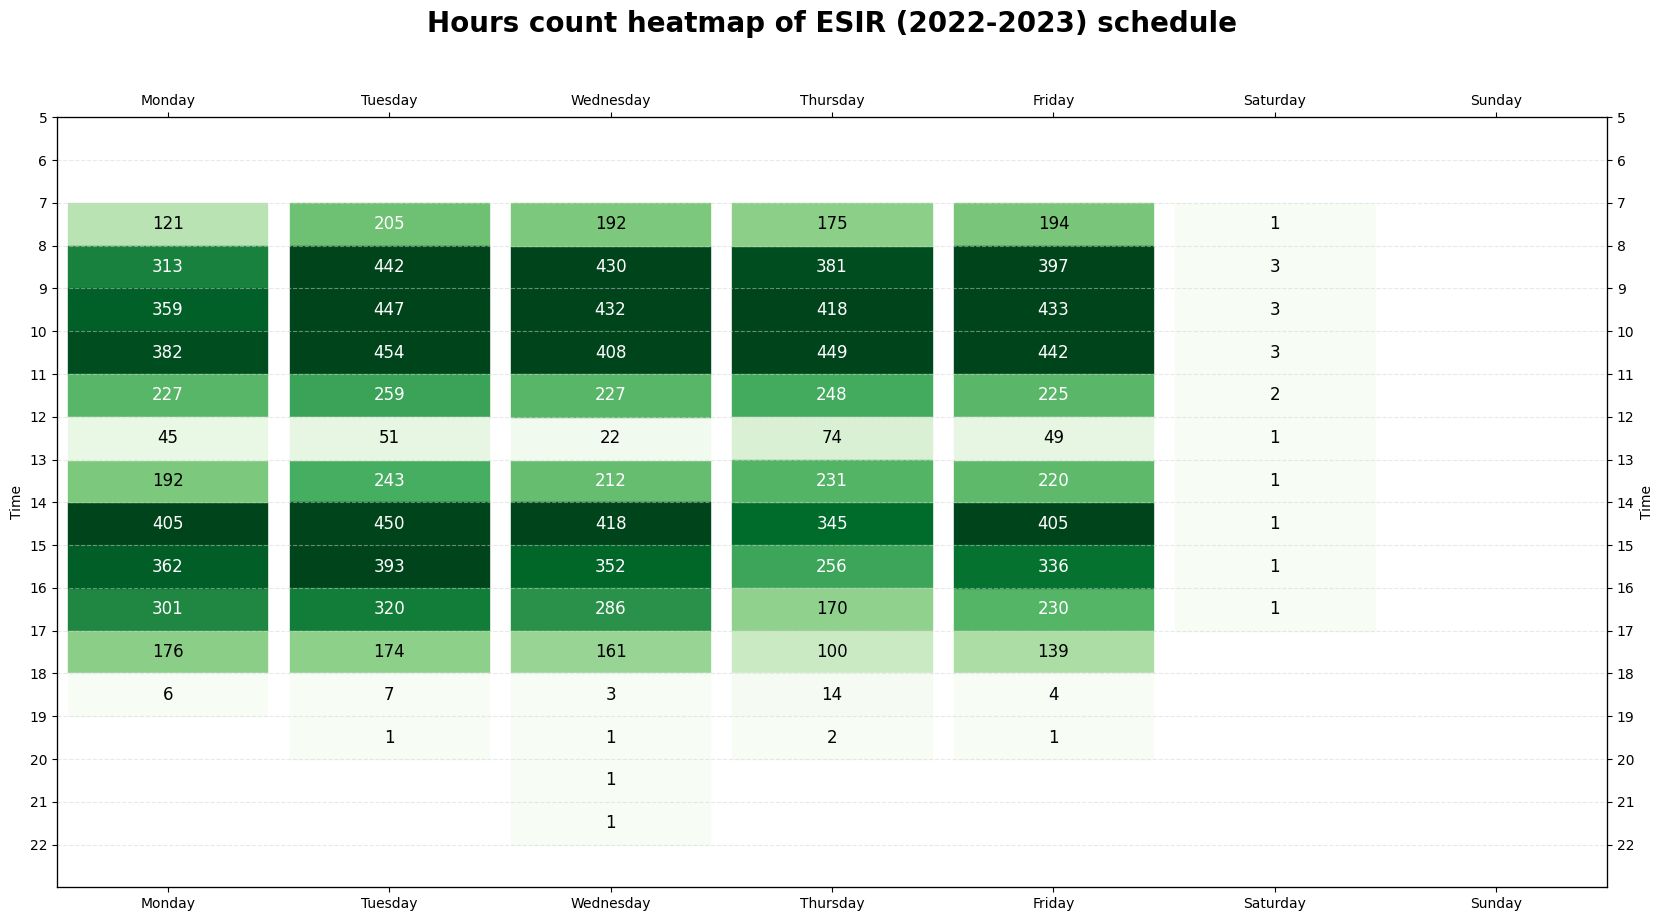

In [153]:

day_to_index = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
max_count = max(hours.values())

# Plot the events
for key in hours.keys():
    hour, day = key
    count = hours[key]
    if day not in day_to_index:
        print('Day {0} not found'.format(day))
        continue
    day_index = day_to_index[day]
    start_hour = hour
    end_hour = hour+1
    
    # Compute the color based on the count and quantiles
    normalized_count = (count-Q1)/(Q3-Q1)
    color =  plt.cm.Greens(normalized_count)
    font_color = 'w' if normalized_count > 0.5 else 'k'
    ax.fill_between([day_index-.45, day_index+.45], [start_hour, start_hour], [end_hour,end_hour], color=color)
    
    # plot event count in this box
    plt.text(day_index, (start_hour+end_hour)*0.5, count, ha='center', va='center', fontsize=12, color=font_color)


# Set Axis

# dot grid
ax.yaxis.grid(True, linestyle='--', which='major', color='lightgrey', alpha=0.5)
ax.set_ylim(23, 5)
ax.set_yticks(range(5,23))
ax.set_ylabel('Time')
ax.set_xlim(0.5,len(day_to_index)+0.5)
ax.set_xticks(range(1,len(day_to_index)+1))
ax.set_xticklabels(day_to_index.keys())

# Set Second Axis
ax2=ax.twiny().twinx()
ax2.set_xlim(ax.get_xlim())
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(ax.get_yticks())
ax2.set_xticks(ax.get_xticks())
ax2.set_xticklabels(day_to_index.keys() )
ax2.set_ylabel('Time')

# add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.gist_heat, norm=plt.Normalize(vmin=0, vmax=max_count))

plt.title(f"Hours count heatmap of {data_name} schedule", fontsize=20, fontweight='bold', y=1.10)

# Feature : Visualize activity per day of the year

In [194]:

def getDate( dt ):
    return pd.to_datetime(dt.date())

# Initialize a Counter with 0 for each day
days = Counter()
start = df['start_time'].min()
end = df['end_time'].max()
cursor = start
while cursor < end:
    days[getDate(cursor)] = 0
    cursor += pd.Timedelta(days=1)


# Count the number of hours per day
for event in df.itertuples():
    days[getDate(event.start_time)] += event.duration.total_seconds()/3600

# Create a DataFrame from the Counter
days_df = pd.DataFrame.from_dict(days, orient='index', columns=['count'])
days_df.head()

,count
2022-09-01,16.75
2022-09-02,29.00
2022-09-03,0.00
2022-09-04,0.00
2022-09-05,59.50


Text(0.5, 1.02, 'Cumulative hours per day of ESIR (2022-2023) schedule')

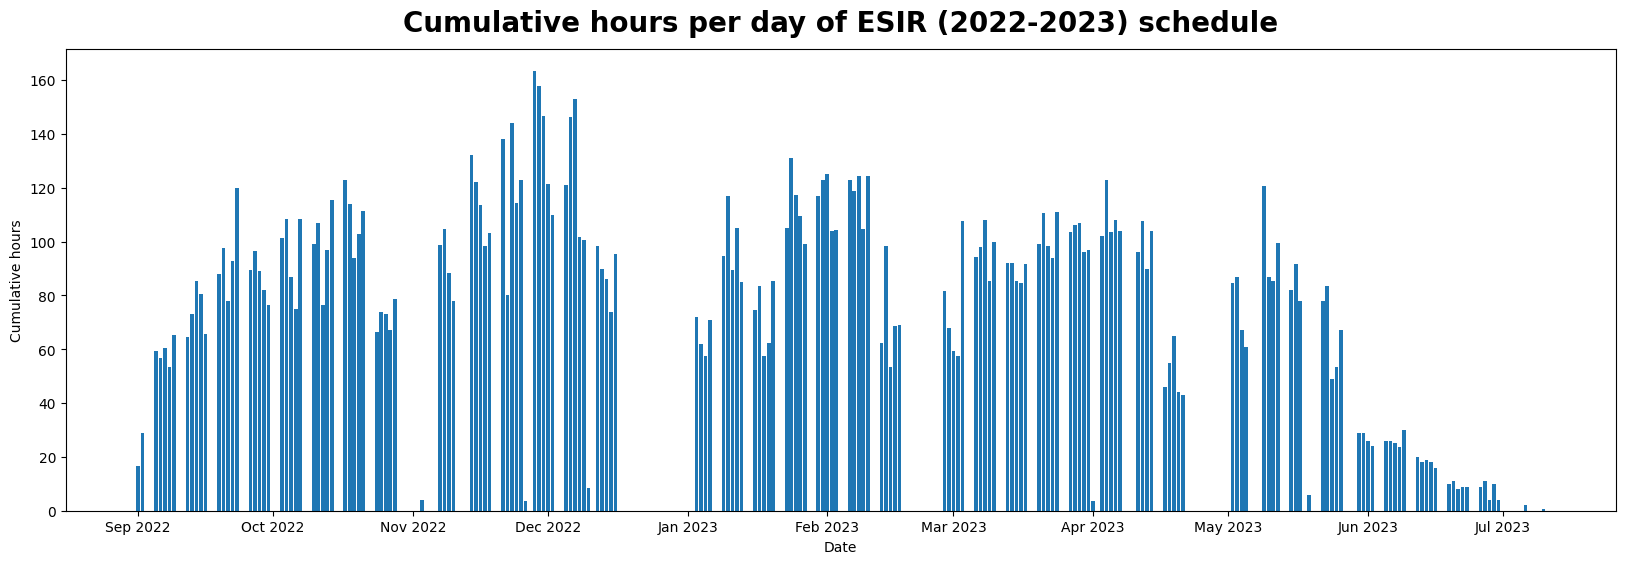

In [197]:
# Sort the data by index
days_df = days_df.sort_index()

# Plot the data
fig, ax = plt.subplots(figsize=(20, 6))
ax.bar(days_df.index, days_df['count'])

# Customize the x-axis tick labels
months = pd.date_range(days_df.index.min(), days_df.index.max(), freq='MS')
month_labels = [month.strftime("%b %Y") for month in months]
ax.set_xticks(months)
ax.set_xticklabels(month_labels, rotation=0, ha='center')


# Customize the plot
plt.ylabel('Cumulative hours')
plt.xlabel('Date')
plt.title(f"Cumulative hours per day of {data_name} schedule", fontsize=20, fontweight='bold', y=1.02)